# Control Systems 1, NB03: Time Response and Stability
2024 ETH Zurich, Mark Benazet Castells, Jonas Holinger, Felix Muller, Matteo Penlington; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli


This interactive notebook is designed to introduce fundamental concepts in control systems engineering. It introduces how to determine the output response and stability of an LTI system.

Authors:
- Jonas Holinger; jholinger@ethz.ch
- Shubham Gupta; shugupta@ethz.ch


## Learning Objectives

After completing this notebook, you should be able to:

1. Understand how to compute the general form response of a linear system by combining its initial condition response and its forced response.
2. Understand the various definitions of stability for a dynamical system.
3. Understand whether an LTI system is asymptotically stable, Lyapunov stable, BIBO stable or unstable by looking at the eigenvalues of the A Matrix

# Setup

## Installing the required packages:


In [ ]:
%pip install numpy matplotlib scipy ipywidgets control IPython

## Import the packages
The following cell imports the required packages. Run it before running the rest of the notebook.

In [2]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from scipy.integrate import odeint
from IPython.display import display, clear_output, Math

# 1. Output Response of a Linear System


Thus far we have seen how to determine the governing equations of a system, how to represent them into standard (state-space) form, and determine whether the system is Linear, Time-Invariant, Causal and Dynamic/Static. Thus, a natural follow-up is how do we compute the output of such a system. 

As previously covered, in this course we consider mainly LTI systems, and thus the following approach details how to compute the output of an LTI system. 

From previous lectures we learned that the definition of linear system is: 
$$
\Sigma (\alpha u_a + \beta u_b) = \alpha (\Sigma u_a) + \beta (\Sigma u_b) = \alpha y_a + \beta y_b
$$
Thus, the idea is to express the output signal as a linear combination of simpler input signals.

Due to causality, we know that the effects of the previous inputs $u_{past}(t)$ can be summarized by the state $x(t)$ at time $t$.
Furthermore, due to time-invariance, the time reference does not matter, hence we can pick any $t$. It follows that it is simpler to pick $t=0$, as this enables us to study separately the effects of non-zero inputs and of non-zero initial conditions. Hence, we are interested in the following two-types of responses:

- **Initial-conditions response:**

  $$
  \left\{
  \begin{array}{ll}
  x_{IC}(0) = x_0 \\
  u_{IC}(t) = 0
  \end{array}
  \right.
  \quad \longrightarrow \quad y_{IC};
  $$

- **Forced response:**

  $$
  \left\{
  \begin{array}{ll}
  x_{F}(0) = 0 \\
  u_{F}(t) = u(t)
  \end{array}
  \right.
  \quad \longrightarrow \quad y_{F}
  $$


The general output of a linear system can be expressed as: $$y = y_{IC}+y_{F}$$

In general note that the solutions to the above can be generalized to:

- **Initial Condition:**
    The initial-condition problem is
    $
    \begin{align}
    \dot x(t) &= A x(t), \quad x(0) = 0 \\
    y(t) &= C x(t)
    \end{align}
    $
    With the corresponding general solution:
    $
    \begin{align}
    x(t) &= e^{At} x(0) \\
    y_{IC}(t) &= C e^{At} x(0)
    \end{align}
    $

- **Forced Response:**
    The forced response problem is:
    $$
    \begin{align}
    \dot x(t) &= Ax(t) + Bu(t), \quad x(0) = 0 \\
    y(t) &= Cx(t) + Du(t)
    \end{align}
    $$
    With the corresponding general solution:
    $$
    \begin{align}
    x(t) &= \int_{0}^t e^{A(t-\tau)Bu(\tau)d\tau} \\
    y(t) &= \int_{0}^t Ce^{A(t-\tau)Bu(\tau)d\tau} + Du(t)
    \end{align}
    $$

Below, we provide a couple examples first, computing the above for a scalar linear system. However, since the $A$ matrix is, in general, not scalar, we later on illustrate how to compute the forced response for when $A$ is a matrix. 

## 1.1 Example: Output Response of a Scalar Linear System


As an example of a scalar linear system lets consider a room with temperature $T(t)$, thermal capacity $C$, and with a heater with power $P(t)$. The room loses heat as a rate of $G(T(t)-T_{amb})$, where $G$ is the thermal conductance. The system is described by the following: 
$$C \frac{dT(t)}{dt} + G \left(T(t) - T_{\text{amb}}\right) = P(t)$$

<div style="text-align:center;">
    <img src="./media/sys4iofo.png" alt="Block Diagram" width="500">
</div>


We choose $x(t) = T(t)$ as our state and $u(t) = P(t)$ as our control input. Further, as winter is approaching, let $T_{amb} = 0$. Thus, the state-space representation of the system is:
$$
\begin{align}
a &= -\frac{G}{C}, &b&= \frac{1}{C} \\
c &= 1, &d&= 0
\end{align}
$$
*Note that we typically use capatilized letters (e.g., $A,B,C,D$) for matrices, and lowercase letters (e.g., $a,b,c,d$) for scalars.* 



In [6]:
#initalise the system

# Define a time vector
time = np.linspace(0, 20, 500)

#Define the param
C = 2
G = 3

# Define state-space system
def create_system(G, C):
    A = -G / C
    B = 1 / C
    C_matrix = 1
    D = 0
    return ct.StateSpace(A, B, C_matrix, D)

# func for generating input
def generate_input(input_type, time_vector):
    if input_type == 'Constant':
        return np.full_like(time_vector, forced_input_slider.value)
    elif input_type == 'Ramp (5s)':
        ramp_duration = 5
        ramp_input = np.clip(np.linspace(0, forced_input_slider.value, int(ramp_duration / time[1])),
                              0, None)
        constant_input = np.full_like(time_vector[int(ramp_duration / time[1]):], forced_input_slider.value)
        return np.concatenate((ramp_input, constant_input))
    elif input_type == 'Ramp (15s)':
        ramp_duration = 15
        ramp_input = np.clip(np.linspace(0, forced_input_slider.value, int(ramp_duration / time[1])),
                              0, None)
        constant_input = np.full_like(time_vector[int(ramp_duration / time[1]):], forced_input_slider.value)
        return np.concatenate((ramp_input, constant_input))
    elif input_type == 'Sinusoidal':
        return forced_input_slider.value * np.sin(0.5 * np.pi * time_vector)  # Frequency can be adjusted

### 1.1.1 Initial Condition Response


To get the initial condition response for the system we need to solve the following ODE: (Let $T_0$ denote the temperature at T=0)
$$
\dot{x}(t)_{IC} = ax(t)_{IC}, 
$$
$$
y(t)_{IC}=cx(t)_{IC}
$$
$$
x(0) = x_0 = T_0
$$

The general solution is known from Analysis :
$$
x(t)_{IC} = e^{at}T_0
$$

$$
y(t)_{IC} = ce^{at}T_0
$$
For our specific problem we get:
$$
y(t)_{IC} = e^{\frac{-G}{C}}T_0
$$

#### Visualization
In the Visualization you can see how the state of our system exponentially decays to zero.

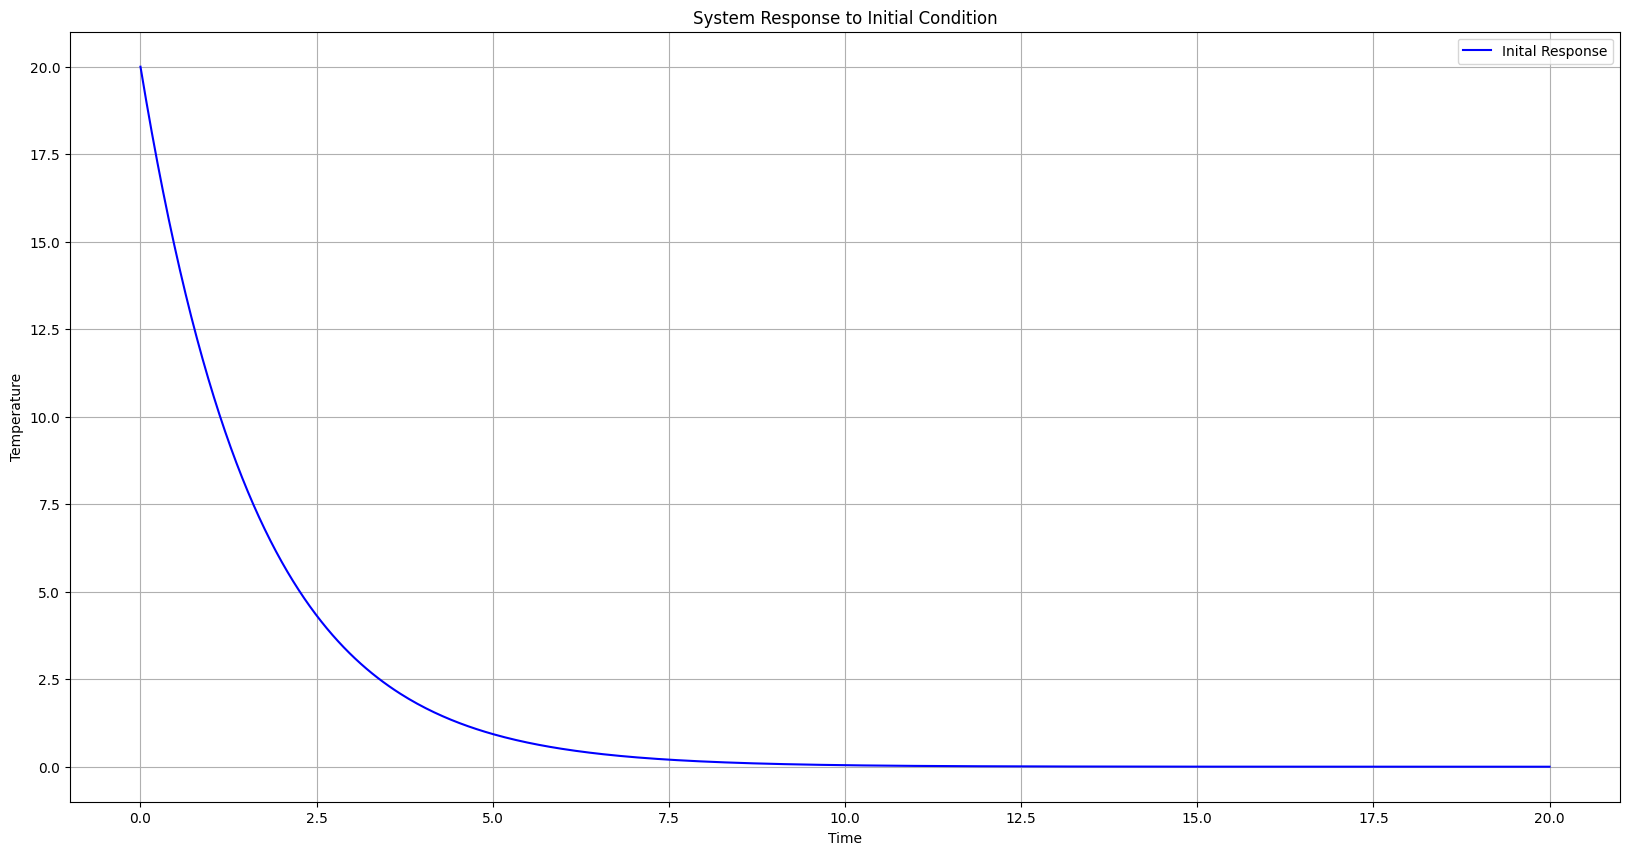

FloatSlider(value=1.9000000000000004, description='G:', max=5.0, min=0.1)

FloatSlider(value=3.1, description='C:', max=5.0, min=0.1)

FloatSlider(value=20.0, description='T0:', max=20.0, min=-20.0, step=0.5)

<IPython.core.display.Math object>

In [4]:
def update_plot_ic(t_0):
    clear_output(wait=True)  # Clear previous output
    system = create_system(G_slider.value, C_slider.value)  
    plt.figure(figsize=(20, 10))
    
    # Simulate the response to the current initial condition
    t, y = ct.initial_response(system, T=time, X0=[t_0])
    
    # Plot the responses
    plt.plot(t, y, label='Inital Response', color='blue')
    plt.title('System Response to Initial Condition')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.grid()
    plt.legend()
    plt.show()
    
    formula = f"y(t) = e^{{\\frac{{-{G_slider.value}}}{{{C_slider.value}}}}} {{{t_0}}}"
    # Display sliders and dropdown again
    display(G_slider, C_slider, t_0_slider)
    display(Math(formula))
    
G_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='G:')
C_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='C:')
t_0_slider = widgets.FloatSlider(value=1.0, min=-20, max=20, step=0.5, description='T0:')

# Observers for the sliders and dropdown
G_slider.observe(lambda change: update_plot_ic(t_0_slider.value), names='value')
C_slider.observe(lambda change: update_plot_ic(t_0_slider.value), names='value')
t_0_slider.observe(lambda change: update_plot_ic(t_0_slider.value), names='value')

# Display sliders and initial plot
display(G_slider, C_slider, t_0_slider)
update_plot_ic(t_0_slider.value)




### 1.1.2 Forced Response



The forced response, which was derived in the lecture with $u(t) \neq 0$ and $x_0 = 0$ is:
$$ x_{FC}=\int_{0}^{t}e^{a\cdot (t-\tau )}bu(\tau )d\tau $$
$$  y_{FC}=\int_{0}^{t}e^{a\cdot (t-\tau )}bu(\tau )d\tau + du(t)$$

#### Visualization
In the visualization you can see how the system reacts to different input types, which can be selected by the drop-down menu. The input slider adjusts how strong the amplitude of the input is. You can show the response due to initial condition and the total response by pressing the buttons.

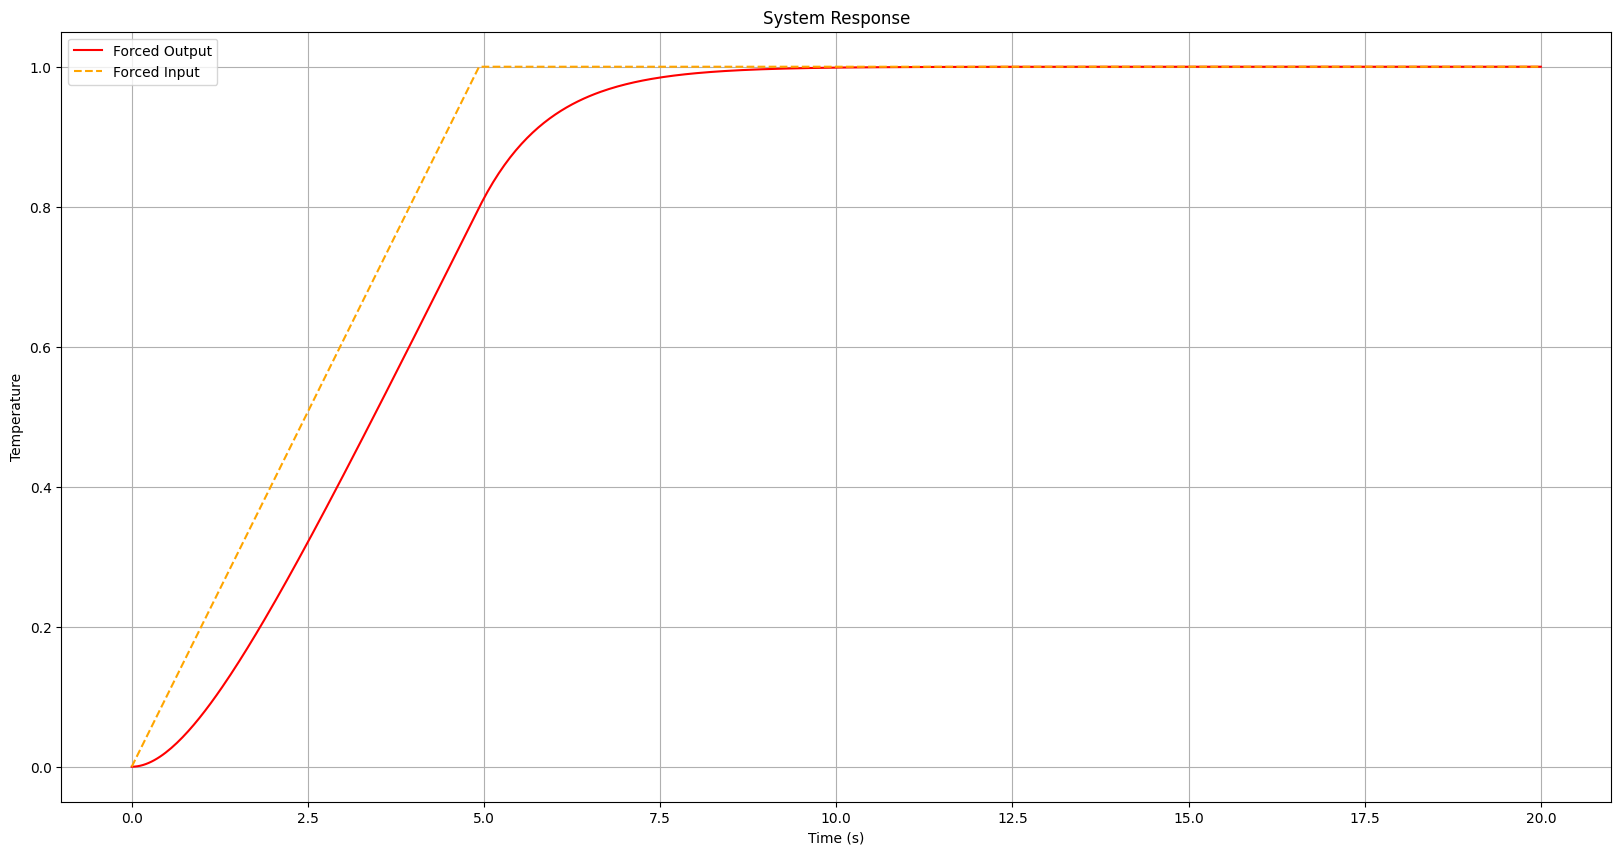

FloatSlider(value=1.0, description='G:', max=5.0, min=0.1)

FloatSlider(value=1.0, description='C:', max=5.0, min=0.1)

FloatSlider(value=1.0, description='T0:', max=40.0, min=-15.0)

FloatSlider(value=1.0, description='Input:', max=30.0, step=0.5)

Dropdown(description='Input Type:', index=1, options=('Constant', 'Ramp (5s)', 'Ramp (15s)', 'Sinusoidal'), va…

ToggleButton(value=False, description='Show Initial Response')

ToggleButton(value=False, description='Show Total Response')

In [5]:
# Function to update the plot
def update_plot_fc(t_0, input_type, show_initial_response, show_total_response):
    clear_output(wait=True)  
    system = create_system(G_slider.value, C_slider.value)  
    
    plt.figure(figsize=(20, 10))

    # Simulate the response to the current initial condition
    t, initial_response = ct.initial_response(system, T=time, X0=[t_0])
    
    # Generate the forced input
    input_fc = generate_input(input_type, time)
    
    # Use control's forced_response to get output for the input signal
    t, forced_response = ct.forced_response(system, T=time, U=input_fc)
    
    # Total response
    total_response = initial_response + forced_response
    
    # Plot the forced input response
    plt.plot(t, forced_response, label='Forced Output', color='red')
    plt.plot(t, input_fc, label='Forced Input', color='orange', linestyle='--')
    # Plot initial response only if the toggle is on
    if show_initial_response:
        plt.plot(t, initial_response, label='Initial Response', color='green')
        
    # Plot total response only if the toggle is on
    if show_total_response:
        plt.plot(t, total_response, label='Total Response', color='blue')

    plt.title('System Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature')
    plt.grid()
    plt.legend()
    plt.show()

    # Display sliders and dropdown again
    display(G_slider, C_slider, t_0_slider, forced_input_slider, 
            input_type_dropdown, show_initial_response_button, 
            show_total_response_button)


# Create sliders for G, C, t_0, and a dropdown for input type
G_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='G:')
C_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='C:')
t_0_slider = widgets.FloatSlider(value=1.0, min=-15.0, max=40.0, step=0.1, description='T0:')
forced_input_slider = widgets.FloatSlider(value=1.0, min=0, max=30.0, step=0.5, description='Input:')
input_type_dropdown = widgets.Dropdown(
    options=['Constant', 'Ramp (5s)', 'Ramp (15s)', 'Sinusoidal'],
    value='Ramp (5s)',
    description='Input Type:'
)

# Create toggle buttons for showing the initial response and total response
show_initial_response_button = widgets.ToggleButton(
    value=False,
    description='Show Initial Response',
    button_style='',  
)

show_total_response_button = widgets.ToggleButton(
    value=False,
    description='Show Total Response',
    button_style='',
)

# Observers for the sliders, dropdown, and toggle buttons
G_slider.observe(lambda change: update_plot_fc(t_0_slider.value, input_type_dropdown.value, 
                                                show_initial_response_button.value, 
                                                show_total_response_button.value), names='value')
C_slider.observe(lambda change: update_plot_fc(t_0_slider.value, input_type_dropdown.value, 
                                                show_initial_response_button.value, 
                                                show_total_response_button.value), names='value')
t_0_slider.observe(lambda change: update_plot_fc(change['new'], input_type_dropdown.value, 
                                                   show_initial_response_button.value, 
                                                   show_total_response_button.value), names='value')
forced_input_slider.observe(lambda change: update_plot_fc(t_0_slider.value, input_type_dropdown.value, 
                                                           show_initial_response_button.value, 
                                                           show_total_response_button.value), names='value')
input_type_dropdown.observe(lambda change: update_plot_fc(t_0_slider.value, change['new'], 
                                                           show_initial_response_button.value, 
                                                           show_total_response_button.value), names='value')
show_initial_response_button.observe(lambda change: update_plot_fc(t_0_slider.value, 
                                                                  input_type_dropdown.value, 
                                                                  change['new'], 
                                                                  show_total_response_button.value), names='value')
show_total_response_button.observe(lambda change: update_plot_fc(t_0_slider.value, 
                                                                 input_type_dropdown.value, 
                                                                 show_initial_response_button.value, 
                                                                 change['new']), names='value')

# Display sliders and initial plot
display(G_slider, C_slider, t_0_slider, forced_input_slider, 
        input_type_dropdown, show_initial_response_button, 
        show_total_response_button)
update_plot_fc(t_0_slider.value, input_type_dropdown.value, 
                show_initial_response_button.value, 
                show_total_response_button.value)


## 2 Output Response of General Linear System

For a system, which is not scalar, we need to compute the matrix exponential.
The definition of our matrix exponential $e^{At}$ is:
$$\frac{de^{At}}{dt}=Ae^{AT}=e^{AT}A$$
We achieve our definition with the following:
$$e^{AT}=I+At+\frac{1}{2}(AT)^{2}+...+\frac{1}{n!}(At)^{n}$$

In python we can use the function `numpy.exp(A)`.



### 2.1 Diagonalization and Jordan Forms
To make our life easier, when calculating the matrix expontential by hand, we want to bring the matrix A into the Diagonal or Jordan form. The solution in these forms looks like this:  



In Diagonal Form:
$$
D = \begin{pmatrix} \lambda_1 t & 0 \\ 0 & \lambda_2 t \end{pmatrix}
$$


$$
e^{D} = \begin{pmatrix} e^{\lambda_1 t} & 0 \\ 0 & e^{\lambda_2 t} \end{pmatrix}
$$


In Jordan Form:
$$
J = \begin{pmatrix} \lambda t & 1t \\ 0 & \lambda t \end{pmatrix}
$$


$$
e^{J} =  \begin{pmatrix} e^{\lambda t} & e^{\lambda t} \\ 0 & e^{\lambda t} \end{pmatrix}
$$

### 2.2 Similarity Transformations
We can use the fact that the choice of a state space model is not unique for a system to transform it to a more suitable form for calculating the matrix exponential by hand. One method to do that is to use similarity transforms.  $A$ and $B$ are similar if $B =  T^{-1}AT$ where T is an invertible Matrix. 
$A$ and $\tilde{A}$ are similiar if $$ \tilde{A} =  T^{-1}AT$$ where T is an invertible Matrix. If we transform the matrices from our state-space model $(A,B,C,D)$ to $(\tilde{A},\tilde{B},\tilde{C},\tilde{D})$ using the similarity transform $x = T \tilde{x}$ and $\tilde{x} = T^{-1}x$, the time response and the eigenvalues stay the same. 

$$
\begin{cases}
\dot{x} = Ax + Bu, \\
y = Cx + Du.
\end{cases}
\quad
$$

we get

$$
\begin{cases}
\dot{\tilde{x}} = (T^{-1} A T) \tilde{x} + (T^{-1} B) u = \tilde{A} \tilde{x} + \tilde{B} u, \\
y = (CT) \tilde{x} + Du = \tilde{C} \tilde{x} + \tilde{D} u.
\end{cases}
$$

To diagnolise $A$, we chose the matrix $T$ whose columns are the eigenvectors of A.

#### 2.2.1 Example
We have a state space model with the following matrices.
$$\begin{array}{c} A = \begin{bmatrix} 0 & 1 \\ -2 & -3 \end{bmatrix}, \quad B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad C = \begin{bmatrix} 1 & 0 \end{bmatrix}, \quad D = 0, \quad x(0) =  \begin{bmatrix} 2 \\ 3 \end{bmatrix} \end{array}$$
To find the Eigenvalues of A we solve: $$\det(A - \lambda I) = 0$$
which gives us the Eigenvalues $\lambda_{1}  = -1$ and $\lambda_{2} = -2$.

We solve $$(A - \lambda I)v = 0$$ to get us the Eigenvectors $ \begin{bmatrix}
1 \\ -1
\end{bmatrix}$ and $\begin{bmatrix}
-1 \\ 2
\end{bmatrix}$
which gives us the matrix $ T = \begin{bmatrix}
1 &  -1\\
-1 &  2\\
\end{bmatrix}
$. We apply the similarity transform to our matrices.


$$\tilde{A} = T^{-1} A T = \begin{bmatrix} -1 & 0 \\ 0 & -2 \end{bmatrix} $$
$$\tilde{B} = T^{-1} B = \begin{bmatrix} 1 \\ 1 \end{bmatrix} $$
$$\tilde{C} = C T = \begin{bmatrix} 1 & -1 \end{bmatrix}$$
$$\tilde{x}_0 = T^{-1}x_0 = \begin{bmatrix} 7 \\ 5 \end{bmatrix}$$
The entries in the diagonal matrix $\tilde{A}$ are the eigenvalues of our matrix $A$. 
Our transformed state response due to initial  conidition is $\tilde{x}(t) = e^{\tilde{A}t}\tilde{x}_{0}$ 
$$\begin{bmatrix}
\tilde{x}_1 \\ \tilde{x}_2 
\end{bmatrix} = \begin{bmatrix}
e^{-1t} &  0\\ 0
&  e^{-2t}\\ 
\end{bmatrix}\begin{bmatrix} 7 \\ 5 \end{bmatrix}$$
We can generalise our state by, because we can express $x_0$ as a linear combination with the eigenvector $v_i$ as a basis.
$$x(t) = \sum_{i=1}^{n} e^{\lambda_i t} \tilde{x}_i(0) v_i$$
The general solution to the initial condition if the eigenvalues are real can be expressed as a linear combination in the form:
$$y(t) = Ce^{At}x_{0}= c_{1}e^{\lambda_1 t}x_{0,1} + c_{2}e^{\lambda_2 t}x_{0,2}$$



### 2.3 Quick Recap about the euler formula

For this course its important to rember the euler formula:

$$e^{i\phi} = \cos \phi + i \sin \phi$$

#### Visualisation
For a more intuitiv understanding of the euler formula, you can see how sin and cos change with respect to $\phi$

In [ ]:
def update_plot_img(phi):
    plt.figure(figsize=(8, 8))
    
    # Create unit circle
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dotted')
    
    fig, ax = plt.subplots()
    ax.add_artist(circle)

    x = np.cos(phi)
    y = np.sin(phi)

    # Plotting the point on the unit circle
    ax.plot([0, x], [0, y], color='red', linewidth=2, label='Radius: e^{iφ}')
    ax.plot(x, y, 'ro')  # Point on the circle

    # Plot the cosine and sine functions
    t = np.linspace(0, 2 * np.pi, 100)
    ax.plot([0, math.cos(phi)], [0, 0], color='green', linestyle='--', linewidth=2, label='cos')
    ax.plot([0, 0], [0, math.sin(phi)], color='blue', linestyle='--', linewidth=2, label='sin')
    # Formatting the plot
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.axhline(0, color='black', linewidth=0.5, ls='--')
    ax.axvline(0, color='black', linewidth=0.5, ls='--')
    ax.set_aspect('equal', 'box')
    ax.set_title(f'$e^{{i{phi:.2f}}} = \\cos({phi:.2f}) + i\\sin({phi:.2f})$', fontsize=14)
    ax.legend()
    plt.grid()
    plt.show()

phi_slider = widgets.FloatSlider(value=0, min=0, max=2 * np.pi, step=0.1, description='φ (radians)')
widgets.interactive(update_plot_img, phi=phi_slider)


## 3. Stability

The notion of stability is central in the study of control theory. The core idea behind stability is that the system should not behave abruptly. The response of the system should be controlled and predictible. Many notions of how to define stability exist.    

1. **Lyapnuov Stability**: A system is called stable in the sense of Lyapunov if, for any initial condition bounded by $\epsilon$, the ouput of the system is remains bounded by $\delta$ for zero input.
$$ 
    ||x(0)||\leq\epsilon\;,\; u(t) = 0 \implies ||x(t)||\leq\delta\;\forall\; t\geq 0
$$
This basically says, if you start close enough to the equillibrium point you can never go too far from it.

2. **Asymptotically stable**: A system is called locally asymptotically stable if for any initial condition bounded by $\epsilon$ the system 
(state) converges to origin as time progresses
$$
    ||x(0)||\leq\epsilon\;,\;u(t) = 0 \; \implies\; \lim_{t\rightarrow\infty}||x(t)|| = 0
$$
This basically goes a step further than lyapunov stability and says that the system not only does not go too far, but also slowly approaches the equillibrium point.  
If this condiiton is satisfied for all possible intial conditions, the systenm is called *gloablly asymptotically stable*.\

Up unitl now for stability, we have considered systems without input. We can also define stability of systems with input.  
3. ****BIBO stability**: A system is called *Bounded Input Bounded Output stable*, if for any bounded input the system will produce an bounded output
$$ 
    ||u(t)||\leq\epsilon\:\forall\;t\geq 0\;,\: x_0=0\;\implies||y(t)||\leq\delta\:\forall\;t\geq 0
$$


### 3.1 Conditions For stability
Now that the notions of stability are known, Lets look into how can we check for them.
For a general system
$$
    \dot{x} = f(x,u)
    y = h(x,u)
$$
The stability can be checked using the linearised system.   
*If the linearised system of a general systemaround the equillibrium point is stable, the non-linear system is **locally** stable around that equillibrium point*.  
The stability being *local* can be understood by the fact that the linearised system only mimics the actual system locally or close to the equillibrium point.  

To check stability for the linear system,  
For a given LTI system
$$
    \dot{x} = Ax + Bu \\
    y = Cx + Du
$$

Stability is determined by the matrix $A$  (here a trivial assumption is that the matrices $B,C,D$ have all finite values). The conditions for stability are as follows, $\lambda_i$ denoting the eigenvalues of $A$:
1. If $A$ is diagonalisable $\implies$ Lyapunov stable if $Re(\lambda_i)\leq 0$,   Asymptotically stable if $Re(\lambda_i)<0$  for all $i$
2. If $A$ is not diagonalisable $\implies$ Lyapunov stable if $Re(\lambda_i)\leq 0$ for all $i$, and no repeated eigenvalues with 0 real part

TODO: Add exmples for diff stability types in the from of graphs

### 3.2 Example: Pendulum Stability

The equations for a pendulum can be derived as follows using Newtonian Mechanics:
$$
    \ddot{\theta} +\frac{g}{l}sin(\theta) = 0
$$

This equation can be converted to the standard state-space form considering the following state vector:
$$
    x = \begin{bmatrix} x_1 \\ x_2\end{bmatrix} = \begin{bmatrix} \theta\\\dot{\theta}\end{bmatrix}
$$
Using this the state space equations are:
$$
    \dot{x} = \begin{bmatrix} \dot{x_1} \\ \dot{x_2}\end{bmatrix} = \begin{bmatrix} \dot{\theta|}\\\ddot{\theta}\end{bmatrix} = \begin{bmatrix} x_2 \\ -\frac{g}{l}sin(x_1)\end{bmatrix}
$$

The equillibrium points for the system can be found using $\dot{x} = 0$, which comes out to be 
$$
    sin(x_1) = sin(\theta) = 0 \\
    \implies \theta = n\pi\; \forall \; n = \{0, \pm 1,\pm 2,\pm 3, \pm 4,\ldots \}
$$

On a closer look, we can see that these are essentially just two equillibrium points, being repeated with a $2\pi$ rotation. The two equillibria being at the bottom ($x_1 = 0$) and the vertical top ($x_1 = \pi$)

Linearising the system around these two equillibrium points we get:

For $x_1 = 0$ equillirium point:
$$
    \dot{x} = \begin{bmatrix} \dot{x_1} \\ \dot{x_2}\end{bmatrix} = \begin{bmatrix} \dot{\theta|}\\\ddot{\theta}\end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -\frac{g}{l} & 0\end{bmatrix} x
$$

Using this formulation the eigenvalues of the $A$ matrix come out to be $\pm i\sqrt(10)$. Since we have two purely imaginary eigen values the system is Lyapunov stbale at this equillibrium point , but not asymptoticcally stable (which makes sense since this is a pendulum without any air drag, hence will continue to oscillate.)

For $x_1 = 0$ equillirium point:
$$
    \dot{x} = \begin{bmatrix} \dot{x_1} \\ \dot{x_2}\end{bmatrix} = \begin{bmatrix} \dot{\theta|}\\\ddot{\theta}\end{bmatrix} = \begin{bmatrix} 0 & 1 \\ \frac{g}{l} & 0\end{bmatrix} x
$$

Using this formulation the eigenvalues of the $A$ matrix come out to be $\pm\sqrt(10)$. Since one of the eigenvalues has real part greater than 0, the system is unstable at this equillibirum (which makes sense, the vertical top is not a stable point).

## 4. Spring and Pendulum System

Continuing from the notebook, we will take a deeper look into the srping and pendulum system shown below.

To refresh your memory,

Consider a pendulum that is mounted to a wall and connected to a horizontal spring as shown in Figure \ref{fig:eng_diag}.
Let $l$ be the length of the pendulum, $J$ its moment of inertia, $m$ its mass, and let $\lambda$ represent the damping constant of the pendulum acting at the pivot (damped rotation due to friction).

Further, let $k$ represent the spring constant of the spring, and denote by $a$ the distance to the pivot of the point that connects the spring and the pendulum. Assume the spring to be relaxed at $\varphi =0$.
The system is actuated by an external force $F(t)$ which acts at a right angle to the pendulum.
There is a sensor measuring the angle $\varphi$ which we assume to be limited to $\varphi(t)\in\left(-\frac{\pi}{2},\frac{\pi}{2}\right)$.

<div style="text-align:center;">
    <img src="./media/pendel.png" alt="Block Diagram" width="400">
</div>

### 4.1 Modelling System Dynamics
The differential equation governing the dynamics of the above described system is assumed to be given by

$$J  \cdot\ddot{\varphi}(t) = -l \cdot m \cdot g  \cdot \sin \varphi(t) - \frac{a^2 \cdot k}{2} \cdot \sin 2\varphi(t) - \lambda \cdot \dot{\varphi}(t) + l\cdot F(t).$$

Further, let the system parameters be
$$
\begin{array}{rcl}
l &=& 1\text{ m}\\[0.2em]
m &=& 1\text{ kg}\\[0.2em]
g &=& 10\text{ m/s}^2\\[0.2em]
a &=& 0.5\text{ m}\\[0.2em]
k &=& 10\text{ N/m}\\[0.2em]
\lambda &=& 3\text{ Nms/rad}\\[0.2em]
J &=& 1\text{ Nms}^2\text{/rad}\\[0.2em]
\end{array}
$$
The initial conditions at $t=0$ are assumed to be such that pendulum is at angle $\varphi=0$ with angular velocity $\dot \varphi =0$.

Choosing the state vector $x(t) = \begin{bmatrix} x_1(t) \\ x_2(t) \end{bmatrix} = \begin{bmatrix} \varphi(t) \\ \dot \varphi(t) \end{bmatrix}$, the input vector $u(t) = F(t)$, and the output vector $y(t) = \varphi(t)$, the system can be represented in state-space form as follows:

$$
\begin{array}{rcl}
\dot{x}(t) &=& \begin{bmatrix} x_2(t) \\ \frac{-l \cdot m \cdot g  \cdot \sin x_1(t) - \frac{a^2 \cdot k}{2} \cdot \sin 2x_1(t) - \lambda \cdot x_2(t) + l\cdot u(t)}{J} \end{bmatrix}\\
y(t) &=& x_1(t)
\end{array}
$$

### 4.2 Linearisation
We can linearize the system around an equilibrium point. In this case, we will linearize it around the equilibrium point $\varphi = 0$, $\dot \varphi = 0$ and $F(t) = 0$.

The linearized system is given by:

$$
\begin{array}{rcl}
\dot{x}(t) &=& \begin{bmatrix} 0 & 1 \\ -\frac{l \cdot m \cdot g + a^2 \cdot k}{J} & -\frac{\lambda}{J} \end{bmatrix} x(t) + \begin{bmatrix} 0 \\ \frac{l}{J} \end{bmatrix} u(t) \\[0.5em]
y(t) &=& \begin{bmatrix} 1 & 0 \end{bmatrix} x(t)
\end{array}
$$


#### 4.2.1 System Stability (Without Control Input)

In [ ]:
# System parameters
l = 1.0  # m
m = 1.0  # kg
g = 10.0  # m/s^2
a = 0.5  # m
k = 10.0  # N/m
lambda_ = 3.0  # Nms/rad
J = 1.0  # Nms^2/rad

# Control input F(t)
def F(t, F1, F2, t1, t2):
    if t < t1:
        return 0
    elif t < t2:
        return F1
    else:
        return F2

# Nonlinear system dynamics
def nonlinear_system(x, t):
    phi, phi_dot = x
    # F_t = F(t, F1, F2, t1, t2)
    phi_ddot = (-l * m * g * np.sin(phi) - 0.5 * a**2 * k * np.sin(2*phi) - lambda_ * phi_dot ) / J
    return [phi_dot, phi_ddot]

# Linear system dynamics
def linear_system(x, t):
    phi, phi_dot = x
    # F_t = F(t, F1, F2, t1, t2)
    phi_ddot = (-l * m * g * phi - a**2 * k * phi - lambda_ * phi_dot ) / J
    return [phi_dot, phi_ddot]

# Simulation and plotting function
def simulate_and_plot( phi0, phi_dot0):
    # Time array
    t = np.linspace(0, 20, 1000)

    # Initial conditions
    x0 = [phi0, phi_dot0]

    # Solve ODEs
    nonlinear_solution = odeint(nonlinear_system, x0, t)
    linear_solution = odeint(linear_system, x0, t)

    # Extract phi and phi_dot
    nonlinear_phi = nonlinear_solution[:, 0]
    linear_phi = linear_solution[:, 0]

    # # Calculate F(t) for plotting
    # F_t = np.array([F(ti,t1, t2) for ti in t])

    # Plotting
    fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))
    fig.suptitle('Pendulum System Simulation: Nonlinear vs Linear', fontsize=16, y=1.05)

    # Plot phi
    ax1.plot(t, nonlinear_phi, label='Nonlinear')
    ax1.plot(t, linear_phi, label='Linear', linestyle='--')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Angle (rad)')
    ax1.set_title('Pendulum Angle (φ)')
    ax1.grid(True)
    ax1.legend()

    # # Plot F(t)
    # ax2.plot(t, F_t)
    # ax2.set_xlabel('Time (s)')
    # ax2.set_ylabel('Force (N)')
    # ax2.set_title('Control Input F(t)')
    # ax2.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, wspace=0.3)
    plt.show()

# Create widgets
# F1_slider = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.1, description='F1:')
# F2_slider = widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description='F2:')
t1_slider = widgets.FloatSlider(value=10, min=0, max=20, step=0.1, description='t1:')
t2_slider = widgets.FloatSlider(value=15, min=0, max=20, step=0.1, description='t2:')
phi0_slider = widgets.FloatSlider(value=0.0, min=-np.pi/2, max=np.pi/2, step=0.01, description='phi_0:')
phi_dot0_slider = widgets.FloatSlider(value=0.0, min=-5, max=5, step=0.01, description='dphi_0:')

# Create interactive output
interactive_plot = widgets.interactive(simulate_and_plot, 
                                    #    F1=F1_slider, F2=F2_slider, 
                                    #    t1=t1_slider, t2=t2_slider,
                                       phi0=phi0_slider, phi_dot0=phi_dot0_slider)

# Display the interactive plot
display(interactive_plot)

### 4.3 Feedback Control:

We now introduce Feedback control inot the system and check for performance. 

In [ ]:
# System parameters
l = 1.0  # m
m = 1.0  # kg
g = 10.0  # m/s^2
a = 0.5  # m
k = 10.0  # N/m
lambda_ = 3.0  # Nms/rad
J = 1.0  # Nms^2/rad

# Control input F(t)
def F(t, K):
    return K 

# Nonlinear system dynamics
def nonlinear_system(x, t, K):
    phi, phi_dot = x
    # F_t = F(t, K)
    phi_ddot = (-l * m * g * np.sin(phi) - 0.5 * a**2 * k * np.sin(2*phi) - lambda_ * phi_dot + l * (K* phi + K* phi_dot)) / J
    return [phi_dot, phi_ddot]

# Linear system dynamics
def linear_system(x, t, K):
    phi, phi_dot = x
    # F_t = F(t, K)
    phi_ddot = (-l * m * g * phi - a**2 * k * phi - lambda_ * phi_dot + l * (K* phi + K* phi_dot)) / J
    return [phi_dot, phi_ddot]

# Simulation and plotting function
def simulate_and_plot(K, phi0, phi_dot0):
    # Time array
    t = np.linspace(0, 30, 1000)

    # Initial conditions
    x0 = [phi0, phi_dot0]

    # Solve ODEs
    nonlinear_solution = odeint(nonlinear_system, x0, t, args=(K,))
    linear_solution = odeint(linear_system, x0, t, args=(K,))

    # Extract phi and phi_dot
    nonlinear_phi = nonlinear_solution[:, 0]
    linear_phi = linear_solution[:, 0]

    nonlinear_phi_dot = nonlinear_solution[:, 1]
    linear_phi_dot = linear_solution[:, 1]

    # Calculate F(t) for plotting
    # F_t = np.array([F(K) for ti in t])

    # Plotting
    fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))
    fig.suptitle('Pendulum System Simulation: Nonlinear vs Linear', fontsize=16, y=1.05)

    # Plot phi
    ax1.plot(t, nonlinear_phi, label='Nonlinear')
    ax1.plot(t, linear_phi, label='Linear', linestyle='--')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Angle (rad)')
    ax1.set_title('Pendulum Angle (φ)')
    ax1.grid(True)
    ax1.legend()

    # # Plot F(t)
    # ax2.plot(t, F_t)
    # ax2.set_xlabel('Time (s)')
    # ax2.set_ylabel('Force (N)')
    # ax2.set_title('Control Input F(t)')
    # ax2.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, wspace=0.3)
    plt.show()

# Create widgets
K_slider = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='K:')
# F2_slider = widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description='F2:')
# t1_slider = widgets.FloatSlider(value=10, min=0, max=20, step=0.1, description='t1:')
# t2_slider = widgets.FloatSlider(value=15, min=0, max=20, step=0.1, description='t2:')
phi0_slider = widgets.FloatSlider(value=0.0, min=-np.pi/2, max=np.pi/2, step=0.01, description='phi_0:')
phi_dot0_slider = widgets.FloatSlider(value=0.0, min=-5, max=5, step=0.01, description='dphi_0:')

# Create interactive output
interactive_plot = widgets.interactive(simulate_and_plot, K =K_slider,
                                    #    F1=F1_slider, F2=F2_slider, 
                                    #    t1=t1_slider, t2=t2_slider,
                                       phi0=phi0_slider, phi_dot0=phi_dot0_slider)

# Display the interactive plot
display(interactive_plot)